# Essai modélisation
### Imports

In [110]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [24]:
df = pd.read_csv(r'C:\Users\ccdeb\Documents\CS\3A\APPRAUTO\TP_soudure_new\tp_appr_auto\data\preprocessed_data.csv')

## Découverte

In [25]:
df.shape

(1463, 33)

In [26]:
#Les seules variables qui manquent encore sont des tests
for k in df:
    if df.dropna(subset=k).shape != df.shape:
        print(k)

Yield strength (MPa)
Ultimate tensile strength (MPa)
Elongation (%)
Reduction of Area (%)
Charpy temperature (deg C)
Charpy impact toughness (J)


In [27]:
df.columns

Index(['C concentration (weight%)', 'Si concentration (weight%)',
       'Mn concentration (weight%)', 'S concentration (weight%)',
       'P concentration (weight%)', 'V concentration (weight%)',
       'O concentration (ppm/weight)', 'Ti concentration (ppm/weight)',
       'N concentration (ppm/weight)', 'Al concentration (ppm/weight)',
       'Current (A)', 'Voltage (V)', 'Heat input (kJ/mm)',
       'Interpass temperature (deg C)',
       'Post weld heat treatment temperature (deg C)',
       'Post weld heat treatment time (hours)', 'Yield strength (MPa)',
       'Ultimate tensile strength (MPa)', 'Elongation (%)',
       'Reduction of Area (%)', 'Charpy temperature (deg C)',
       'Charpy impact toughness (J)', 'AC', 'electrode positive',
       'Type of weld_GMAA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA'],
      dtype='object')

## Stratégie cible
On se rend compte qu'il n'y a pas de variable cible claire. Je propose donc d'établir une définition de la cible basée sur une combinaison des seuils sur les tests. Cela me permettra d'avoir une variable cible booléenne. 
 
Voici la liste des colonnes représentant les tests : 

In [28]:
col_test = ['Yield strength (MPa)','Ultimate tensile strength (MPa)', 'Elongation (%)',
            'Reduction of Area (%)','Charpy impact toughness (J)']

df = df.drop('Charpy temperature (deg C)',axis=1) #la température de charpy dépend trop du type d'acier 

Analyse des variables cibles

In [29]:
#On regarde le nombre de valeurs qui n'ont aucun test
dfd = df.copy()
Lt=[]
dfd['nb'] = 0
for c in col_test:
    n=c+'_test'
    dfd[n] = np.where(dfd[c].isna(),0,1)
    Lt.append(n)
    dfd['nb'] = dfd['nb'] + dfd[n]

dfd['nb'].value_counts()


nb
1    650
4    510
5    134
0     82
3     52
2     35
Name: count, dtype: int64

Sur 1463 pièces, 82 n'ont aucuns tests. Vu la quantité, on peut sûrement les supprimer.

In [30]:
print(df.shape,'\n')
for k in col_test:
    print(k,':',df[k].nunique())

(1463, 32) 

Yield strength (MPa) : 325
Ultimate tensile strength (MPa) : 303
Elongation (%) : 135
Reduction of Area (%) : 122
Charpy impact toughness (J) : 143


Sur plus de 1400 lignes, on se rend compte qu'il n'y a pas tant de valeurs différentes que ça. Il serait intéressant d'appliquer un algorithme des plus proches voisins afin de prédire les valeurs manquantes. En plus les variables sont prêtes pour un KNN vu qu'elles sont normalisées et cela permettra d'avoir le maximum d'informations  
## Application KNN

In [31]:
#Récupération des colonnes quanti
quanti = df.select_dtypes(include=['Float64']).columns

In [50]:
#Préparation du df qui va avoir les nouvelles colonnes de tests
dfknn = df.copy()

#préparation du df pour appliquer le knn et prédire les colonnes de test 
dfknn = df[quanti]

#application du knn sur les données quanti pour prédire 
imputer = KNNImputer(n_neighbors=5)
dfknn = imputer.fit_transform(dfknn)

#mise en forme du tableau 
dfknn = pd.DataFrame(dfknn)
dfknn.columns = quanti
dfinter = df.drop(columns=quanti,axis=1).reset_index()
dfknn = dfknn.reset_index()

#merge du tableau pour avoir les données booléennes, quanti et les variables cibles
dfknn = dfinter.merge(dfknn,on='index',how='left')


Etant donné que les données des tests sont normalisées, je dois aussi normaliser les seuils  
### Normalisation des seuils  
#### Récupération moyenne/std

In [62]:
#Récupération des mean/std
data = pd.read_table("../data/welddb.data",sep = " ", header=None)
data.replace('N', None, inplace=True)
data.columns = ["C concentration (weight%)","Si concentration (weight%)", "Mn concentration (weight%)","S concentration (weight%)", "P concentration (weight%)", "Ni concentration (weight%)", "Cr concentration (weight%)", "Mo concentration (weight%)", "V concentration (weight%)", "Cu concentration (weight%)", "Co concentration (weight%)", "W concentration (weight%)", "O concentration (ppm/weight)", "Ti concentration (ppm/weight)", "N concentration (ppm/weight)", "Al concentration (ppm/weight)", "B concentration (ppm/weight)", "Nb concentration (ppm/weight)", "Sn concentration (ppm/weight)", "As concentration (ppm/weight)", "Sb concentration (ppm/weight)", "Current (A)", "Voltage (V)", "AC or DC", "Electrode positive or negative", "Heat input (kJ/mm)", "Interpass temperature (deg C)", "Type of weld", "Post weld heat treatment temperature (deg C)", "Post weld heat treatment time (hours)", "Yield strength (MPa)", "Ultimate tensile strength (MPa)", "Elongation (%)", "Reduction of Area (%)", "Charpy temperature (deg C)", "Charpy impact toughness (J)", "Hardness (kg/mm2)", "50 FATT", "Primary ferrite in microstructure (%)", "Ferrite with second phase (%)", "Acicular ferrite (%)", "Martensite(%)", "Ferrite with carbide aggreagate (%)", "Weld ID"]
data = data.replace("<","",regex=True)
data['N concentration (ppm/weight)'] = data['N concentration (ppm/weight)'].str.split("tot").str[0]
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("(").str[0]
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("H").str[0]
data['Interpass temperature (deg C)'] = data['Interpass temperature (deg C)'].replace('150-200','175')
for i, column in enumerate(data.columns):
    if i not in [23,24,27,43]:
        data[column] = data[column].astype(float)

data.columns = data.columns.map(str)
data = data[col_test]
means = data.mean()
stds = data.std()

#### Définition des seuils  
Vu que je ne me suis pas spécialisée dans l'ingénieurerie mécanique je me suis aidée de chatgpt pour les définir 

In [63]:
Seuils = {
    'Yield strength (MPa)' : {350:[]},
    'Ultimate tensile strength (MPa)' : {500:[]},
    'Elongation (%)': {20:[]},
    'Reduction of Area (%)':{20:[]},
    'Charpy impact toughness (J)':{50:[]}
}

for c in col_test:
    val = list(Seuils[c].keys())[0]
    Seuils[c][val] = (val - means[c]) / stds[c]


### Définition de "bonne soudure" : a réussi tous les test en étant au dessus de tous les seuils normalisés

In [81]:
dftsh = dfknn.copy()
Lt = []
#Est-ce que la colonne de test est au dessus du seuil ?
for k in col_test:
    c = k+'_test'
    seuil = list(Seuils[k].keys())[0]
    dftsh[c]=np.where(dftsh[k]>Seuils[k][seuil],1,0)
    Lt.append(c)

#Calcul du nombre de test réussi pour chaque observation
dftsh['nb_test_reussi'] = 0
for k in Lt:
    dftsh['nb_test_reussi'] += dftsh[k]

#Création de la cible
dftsh['y'] = np.where(dftsh['nb_test_reussi']==len(Lt),1,0)
Lt.append('nb_test_reussi')
dftsh = dftsh.drop(columns=Lt,axis=1)

In [82]:
dftsh['y'].value_counts()

y
1    962
0    501
Name: count, dtype: int64

Il n'y a pas d'énormes différences d'échelles sur le volume, on peut donc continuer  
## Application ACP  
#### Préparation

In [102]:
bool = dftsh.select_dtypes(include=['bool'])
Dmap = {True:1,False:0}
dfacp = dftsh.copy()
for c in bool:
    dfacp[c] = dfacp[c].map(Dmap)
dfacp = dfacp.drop(columns='index',axis=1) #Il ne faudrait pas appliquer l'acp sur l'index
dfacpx = dfacp.drop(columns='y',axis=1) #Il ne faudrait pas appliquer l'acp sur la cible
dfacpx = dfacpx.drop(columns=col_test,axis=1) #Il ne faudrait pas appliquer l'acp sur "presque" la cible

#### Application

In [103]:
acp = PCA()
acp.fit(dfacpx)

print(acp.explained_variance_ratio_ * 100)


[2.08328441e+01 1.60608471e+01 1.18599796e+01 7.31955969e+00
 7.06619375e+00 6.29734473e+00 5.31094890e+00 4.79866436e+00
 4.06478563e+00 3.54929464e+00 3.11539768e+00 2.95601111e+00
 2.36523158e+00 2.26858370e+00 7.94494713e-01 4.40160187e-01
 3.00339558e-01 2.04634989e-01 1.21029957e-01 8.20295274e-02
 5.60192608e-02 3.70493740e-02 2.99433438e-02 2.50493707e-02
 1.74266762e-02 1.58651729e-02 1.02712628e-02]


La lisre n'est pas très lisible pour la prise de décision. Je décide faire un graphique des variances cumulées pour mieux me faire une idée

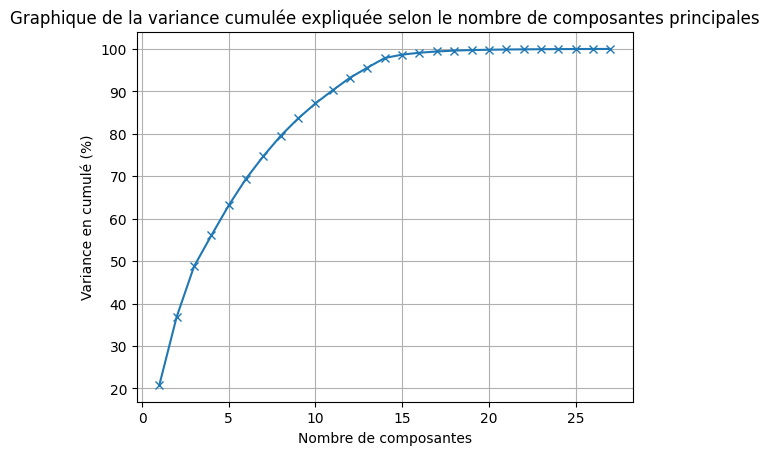

In [106]:
# variance expliquée cumulée
varcum = acp.explained_variance_ratio_.cumsum()

# Graphique pour prise de décision 
plt.plot(range(1, len(varcum) + 1), varcum * 100, marker='x')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance en cumulé (%)')
plt.title('Graphique de la variance cumulée expliquée selon le nombre de composantes principales')
plt.grid(True)
plt.show()

On se rend compte qu'en divisant par deux le nombre de composante on retrouve 95% des informations. Ce qui est largement suffisant pour de la modélisation.

In [109]:
acp = PCA(n_components=13)
X_acp = acp.fit_transform(dfacpx)

var_tot = sum(acp.explained_variance_ratio_) * 100
print("Variance totale :",var_tot,'%')

Variance totale : 95.59710290563642 %


## Modélisation

In [111]:
#Séparation